<a href="https://colab.research.google.com/github/MohamedAhmed35/computer-vision/blob/main/object-detection/R-CNN/cat_dog_detection/02_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.regularizers import l2
from keras.optimizers import Adam

import sys
import os

sys.path.append('/content/drive/MyDrive/Colab Notebooks/R-CNN')
import helper_functions as helper

In [ ]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/R-CNN/data"
processed_dir = os.path.join(data_dir, "processed")
train_dir = os.path.join(processed_dir, "train_dir")
test_dir = os.path.join(processed_dir, "test_dir")

train_csv_path = os.path.join(train_dir, "CSV_files")
test_csv_path = os.path.join(test_dir, "CSV_files")

df_train = pd.read_csv(os.path.join(processed_dir, "train_data.csv"))
df_test = pd.read_csv(os.path.join(processed_dir, "test_data.csv"))

## VGG16

In [ ]:
# Load a pretrained alexnet model. The source from the internet
base_model = tf.keras.applications.VGG16(weights="imagenet")

# Preserve the weights of each layer
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 138,357,544 (527.79 MB)

## Cat SVM classification Model

### Load Cat feature vectors

In [ ]:
cat_train = pd.read_csv(os.path.join(train_csv_path, "cat_train.csv"))
cat_test = pd.read_csv(os.path.join(test_csv_path, "cat_test.csv"))

# Extract features by dropping the label column as numpy array
train_features = cat_train.drop(columns = ['label']).values  # .values returns a numpy array
test_features = cat_test.drop(columns = ['label']).values   # Extract test features
# Extracting the label column as numpy array
train_labels = cat_train['label'].values                    # Extract train labels
test_labels = cat_test['label'].values                      # Extract test labels

### Train Cat SVM model

In [ ]:
# Create a pipeline for scaling and training SVM
cat_svm_model = make_pipeline(StandardScaler(), SVC(kernel = "linear", probability = True, class_weight='balanced', C = 0.001))

# Train the SVM
cat_svm_model.fit(train_features, train_labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=0.001, class_weight='balanced', kernel='linear',
                     probability=True))])

### Test Cat SVM model

model accuracy: 99.27%
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.65      0.64       198
           1       1.00      1.00      1.00     19407

    accuracy                           0.99     19605
   macro avg       0.82      0.82      0.82     19605
weighted avg       0.99      0.99      0.99     19605



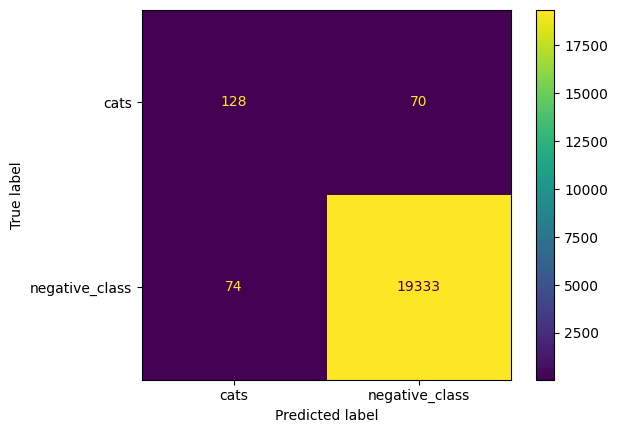

In [ ]:
# Test the SVM
cat_pred = cat_svm_model.predict(test_features)

# Calculate accuracy
accuracy  = accuracy_score(test_labels, cat_pred)
print(f"model accuracy: {(accuracy * 100):0.2f}%")

print("Classification Report:")
print(classification_report(test_labels, cat_pred))

cm = confusion_matrix(test_labels, cat_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["cats", "negative_class"])
disp.plot()

### Save Cat SVM model as pickle

In [ ]:
# Save the cat SVM model using pickle
with open("/content/drive/MyDrive/Colab Notebooks/R-CNN/models/cat_svm_model.pkl", 'wb') as file:
    pickle.dump(cat_svm_model, file)

## Dog SVM Classification Model

### Load Dog feature vectors

In [ ]:
dog_train = pd.read_csv(os.path.join(train_csv_path, "dog_train.csv"))
dog_test = pd.read_csv(os.path.join(test_csv_path, "dog_test.csv"))

# Extract features by dropping the label column as numpy array
train_features = dog_train.iloc[:, :-1].values      # .values returns a numpy array as to_numpy method
test_features = dog_test.iloc[:, :-1].values        # Extract test features
# Extracting the label column as numpy array
train_labels = dog_train.iloc[:, -1].values         # Extract train labels
test_labels = dog_test.iloc[:, -1].values           # Extract test labels

### Train Dog SVM model

In [ ]:
# Create a pipeline for scaling and training SVM with soft margin, C = 0.001, to detect true values of minor class regarding the major class
dog_svm_model = make_pipeline(StandardScaler(), SVC(kernel = "linear", probability = True, class_weight='balanced', C = 0.001))

# Train the SVM
dog_svm_model.fit(train_features, train_labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=0.001, class_weight='balanced', kernel='linear',
                     probability=True))])

### Test Dog SVM model

accuracy: 98.99%
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.62      0.63       269
           1       0.99      1.00      0.99     19314

    accuracy                           0.99     19583
   macro avg       0.82      0.81      0.81     19583
weighted avg       0.99      0.99      0.99     19583



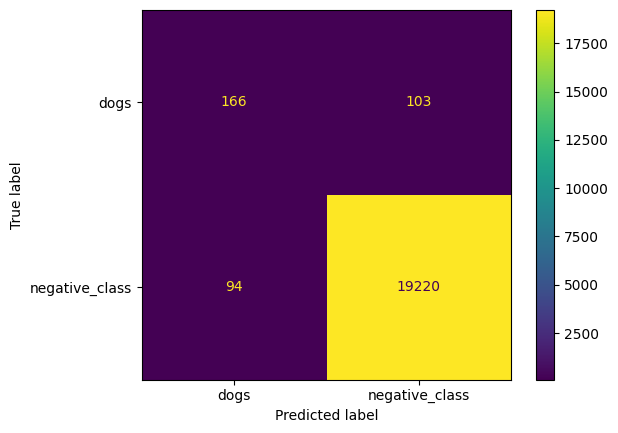

In [ ]:
# Test the SVM
dog_pred = dog_svm_model.predict(test_features)

# Calculate accuracy
accuracy  = accuracy_score(test_labels, dog_pred)
print(f"accuracy: {(accuracy*100):0.2f}%")

print("Classification Report:")
print(classification_report(test_labels, dog_pred))

cm = confusion_matrix(test_labels, dog_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["dogs", "negative_class"])
disp.plot()

### Save Dog SVM model as pickle

In [ ]:
# Save the dog SVM model using pickle
with open("/content/drive/MyDrive/Colab Notebooks/R-CNN/models/dog_svm_model.pkl", 'wb') as file:
    pickle.dump(dog_svm_model, file)

## Regressor Model

In [ ]:
x = base_model.layers[-4].output

x = tf.keras.layers.Dense(4, "linear", kernel_regularizer= l2(0.0001))(x)

regressor_model = tf.keras.models.Model(inputs = base_model.input, outputs = x)

regressor_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │         100,356 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,815,044 (56.51 MB)

 Trainable params: 100,356 (392.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Prepare the data for the regressor model

In [ ]:
train_images, train_labels = helper.get_regressor_data(train_dir, df_train)
test_images, test_labels = helper.get_regressor_data(test_dir, df_test)

### Train the Model

In [ ]:
# Model parameters
batch_size = 8
epochs = 20             # based on loss-epochs plotting
opt = Adam(learning_rate  = 0.0001)

In [ ]:
regressor_model.compile(loss = 'mean_squared_error', optimizer = opt)

In [ ]:
history = regressor_model.fit(x = train_images,
                              y = train_labels,
                              batch_size = batch_size,
                              epochs = epochs,
                              shuffle=True,
                              verbose = 1
                              )

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.4302
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.1443
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0745
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0956
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0416
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0338
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0246
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0241
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0107
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0082
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0125
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0081
Epoch 13/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0067
Epoch 14/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0075
Epoch 15/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0061
E

### Plotting Model history

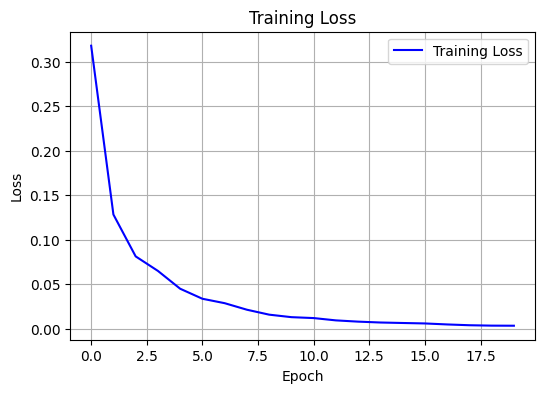

In [ ]:
# Plotting training loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()

### Model prediction and evaluation

In [ ]:
# Predict transformation parameters
pred_labels = regressor_model.predict(test_images)

7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step


In [ ]:
# Model evaluation
regressor_model.evaluate(test_images, test_labels)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 0.1508


0.18479199707508087

In [ ]:
regressor_model.save("/content/drive/MyDrive/Colab Notebooks/R-CNN/models/regressor.keras")